<center>

##  Simulation   

</center> 


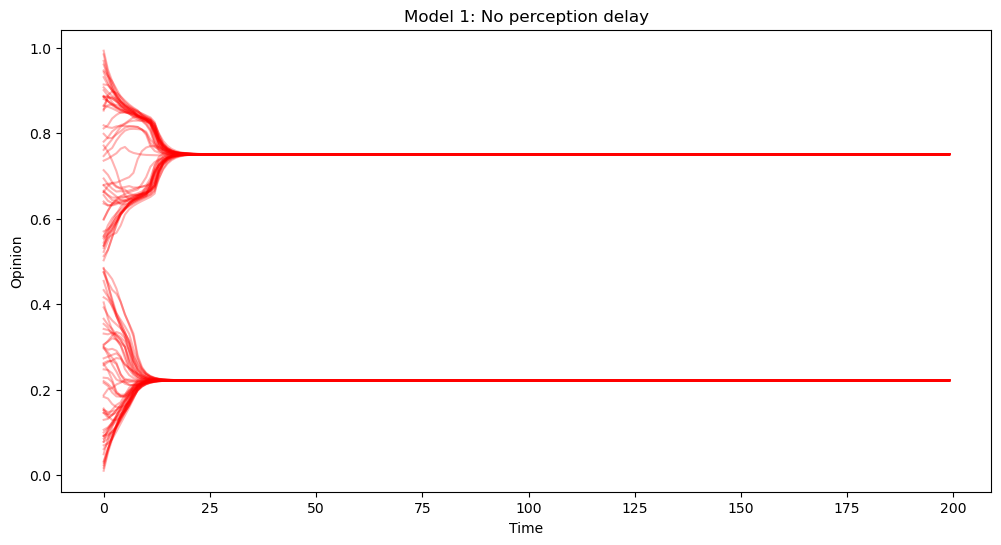

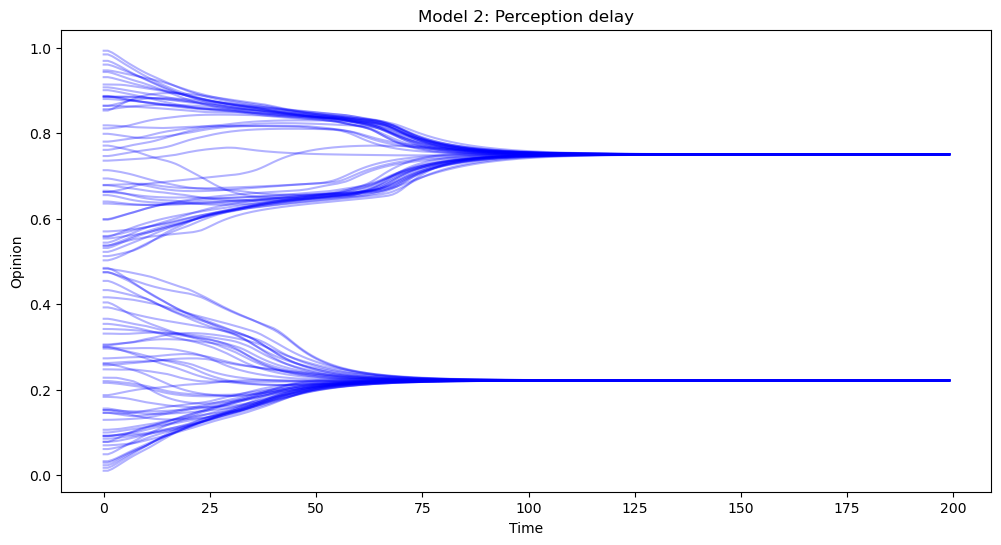

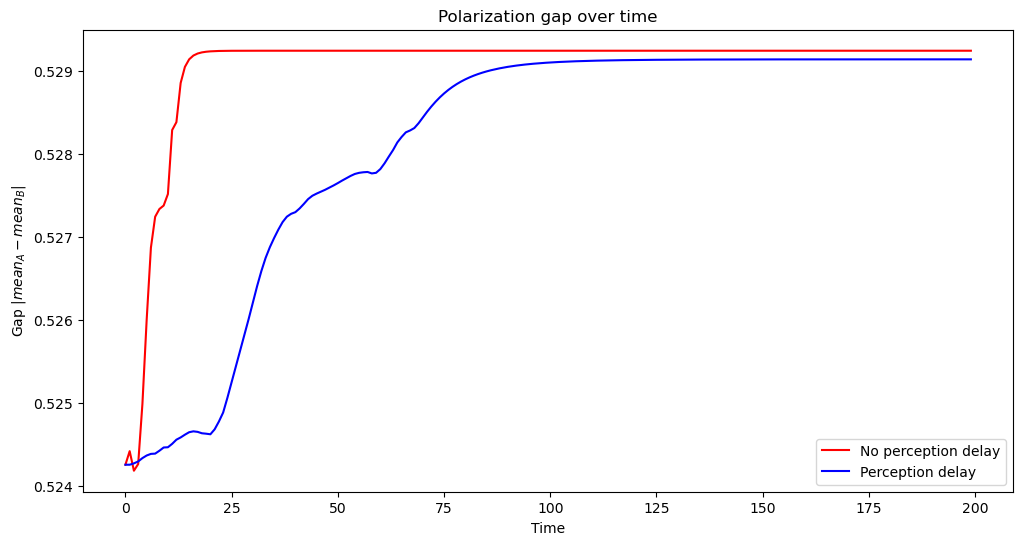

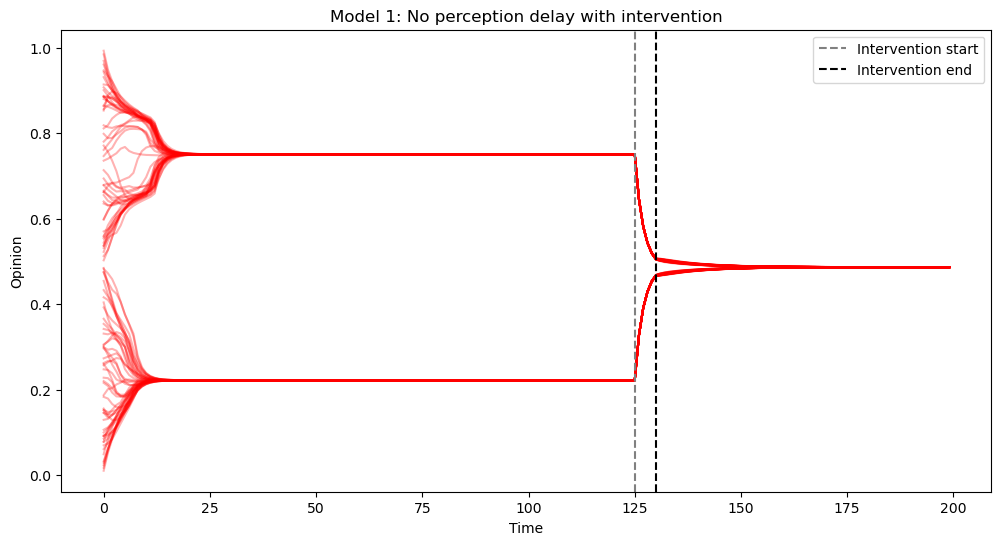

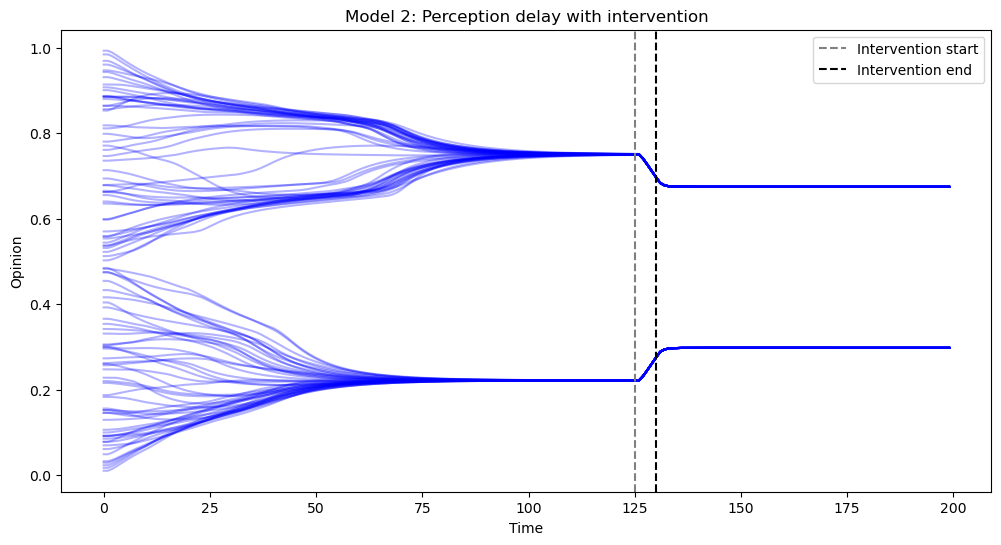

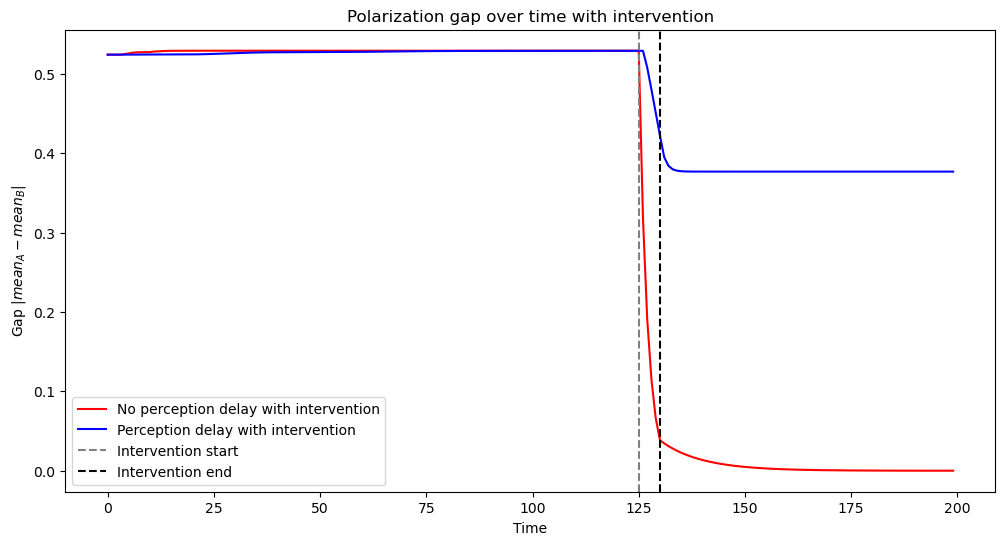

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Simulation parameters
N = 100
k = 2
sizes = [N//k]*k

p_in = 0.5      # stronger within-community
p_out = 0.05    # weaker cross-community

T = 200
mu = 0.5        # opinion update rate 
epsilon = 0.15  # BCM threshold

# fixed delay parameter
tau_fixed = 10.0

# intervention parameters
t_intervene = 125        # intervention start
t_duration = 5          # intervention duration
eta = 0.8               #  intervention strength

np.random.seed(42)


# SBM Network
P = np.full((k, k), p_out)
np.fill_diagonal(P, p_in)
G = nx.stochastic_block_model(sizes, P, seed=42)

A = nx.to_numpy_array(G)
neighbors_list = [np.where(A[i] > 0)[0] for i in range(N)]

# Initial opinions (single IC)
x0 = np.zeros(N)
x0[:sizes[0]] = np.random.uniform(0.0, 0.5, sizes[0])
x0[sizes[0]:] = np.random.uniform(0.5, 1.0, sizes[1])

p0 = x0.copy()  # initial perceived opinion for delayed model



# polarization metric
def polarization_gap(history):
    """Compute |mean(group1) - mean(group2)| over time."""
    half = history.shape[0] // 2
    g1 = history[:half].mean(axis=0)
    g2 = history[half:].mean(axis=0)
    return np.abs(g1 - g2)



# Baseline models (no intervention)
def model1_no_delay(x_init):
    x = x_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()
        x_new = x.copy()

        for i in range(N):
            # neighbors under BCM condition
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])  # social signal s_i(t)
                x_new[i] = x[i] + mu * (s_i - x[i])

        x = x_new.copy()
    return history

def model2_fixed_delay(x_init, p_init):
    x = x_init.copy()
    p = p_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()

        x_new = x.copy()
        p_new = p.copy()

        for i in range(N):
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])  # social signal s_i(t)

                # perception update: p_i(t+1)
                p_new[i] = p[i] + (1 / tau_fixed) * (s_i - p[i])

                # opinion update uses p_i(t)
                x_new[i] = x[i] + mu * (p[i] - x[i])

        x = x_new.copy()
        p = p_new.copy()
    return history


# Run baseline simulations (no intervention)
history1 = model1_no_delay(x0)
history2 = model2_fixed_delay(x0, p0)

gap1 = polarization_gap(history1)
gap2 = polarization_gap(history2)


# Plot baseline opinions
titles = ["Model 1: No perception delay",
          "Model 2: Perception delay"]
colors = ["red", "blue"]
histories = [history1, history2]

for hist, title, color in zip(histories, titles, colors):
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(hist[i], alpha=0.3, color=color)
    plt.title(title + "")
    plt.xlabel("Time")
    plt.ylabel("Opinion")
    plt.show()

plt.figure(figsize=(12, 6))
plt.plot(gap1, label="No perception delay", color="red")
plt.plot(gap2, label="Perception delay", color="blue")
plt.title("Polarization gap over time")
plt.xlabel("Time")
plt.ylabel("Gap $|mean_A - mean_B|$")
plt.legend()
plt.show()


# Models with intervention (same network + initial state)
def model1_no_delay_intervention(x_init):
    x = x_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()
        x_new = x.copy()

        u = x.mean()  # global signal u(t)
        I_t = (t_intervene <= t < t_intervene + t_duration)

        for i in range(N):
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])  # social signal
            else:
                s_i = x[i]

            # instantaneous perception with possible intervention
            if I_t:
                p_i = (1 - eta) * s_i + eta * u
            else:
                p_i = s_i

            x_new[i] = x[i] + mu * (p_i - x[i])

        x = x_new.copy()
    return history


def model2_fixed_delay_intervention(x_init, p_init):
    x = x_init.copy()
    p = p_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()

        x_new = x.copy()
        p_new = p.copy()

        u = x.mean()  # global signal
        I_t = (t_intervene <= t < t_intervene + t_duration)

        for i in range(N):
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])
            else:
                s_i = x[i]

            # base perception update from neighbors
            dp = (1 / tau_fixed) * (s_i - p[i])

            # intervention contribution on p
            if I_t:
                dp += (eta / tau_fixed) * (u - p[i])

            p_new[i] = p[i] + dp

            # opinion update uses p(t)
            x_new[i] = x[i] + mu * (p[i] - x[i])

        x = x_new.copy()
        p = p_new.copy()
    return history



# Run simulations with intervention
hist1_int = model1_no_delay_intervention(x0)
hist2_int = model2_fixed_delay_intervention(x0, p0)

gap1_int = polarization_gap(hist1_int)
gap2_int = polarization_gap(hist2_int)


# Plot trajectories with intervention
titles_int = ["Model 1: No perception delay with intervention",
              "Model 2: Perception delay with intervention"]
colors_int = ["red", "blue"]
histories_int = [hist1_int, hist2_int]

for hist, title, color in zip(histories_int, titles_int, colors_int):
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(hist[i], alpha=0.3, color=color)
    plt.axvline(t_intervene, color="grey", linestyle="--",
                label="Intervention start")
    plt.axvline(t_intervene + t_duration, color="black", linestyle="--",
                label="Intervention end")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Opinion")
    plt.legend()
    plt.show()

# polarization gaps with intervention
plt.figure(figsize=(12, 6))
plt.plot(gap1_int, label="No perception delay with intervention", color="red")
plt.plot(gap2_int, label="Perception delay with intervention", color="blue")
plt.axvline(t_intervene, color="grey", linestyle="--",
            label="Intervention start")
plt.axvline(t_intervene + t_duration, color="black", linestyle="--",
            label="Intervention end")
plt.title("Polarization gap over time with intervention")
plt.xlabel("Time")
plt.ylabel("Gap $|mean_A - mean_B|$")

# Place the legend in the lower left corner
plt.legend(loc='lower left')
plt.show()

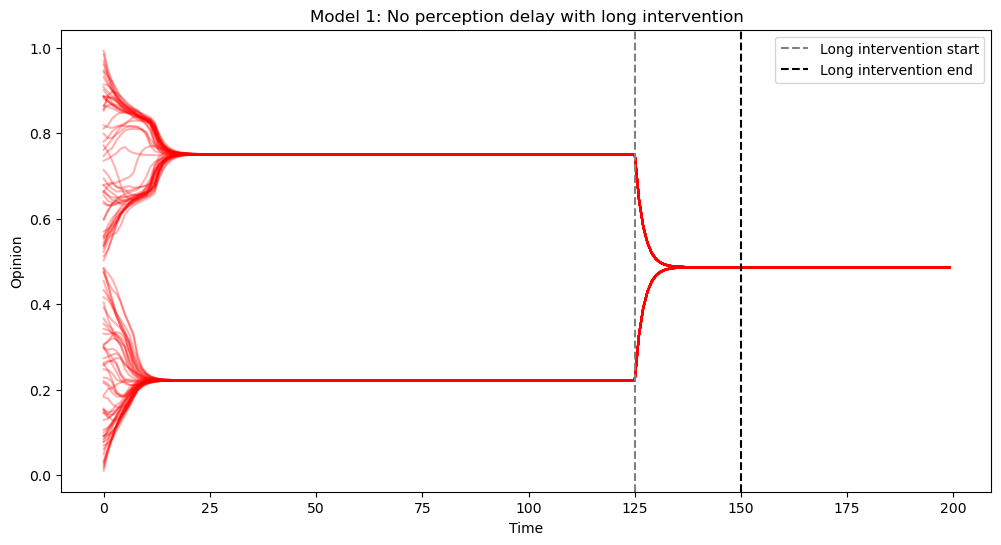

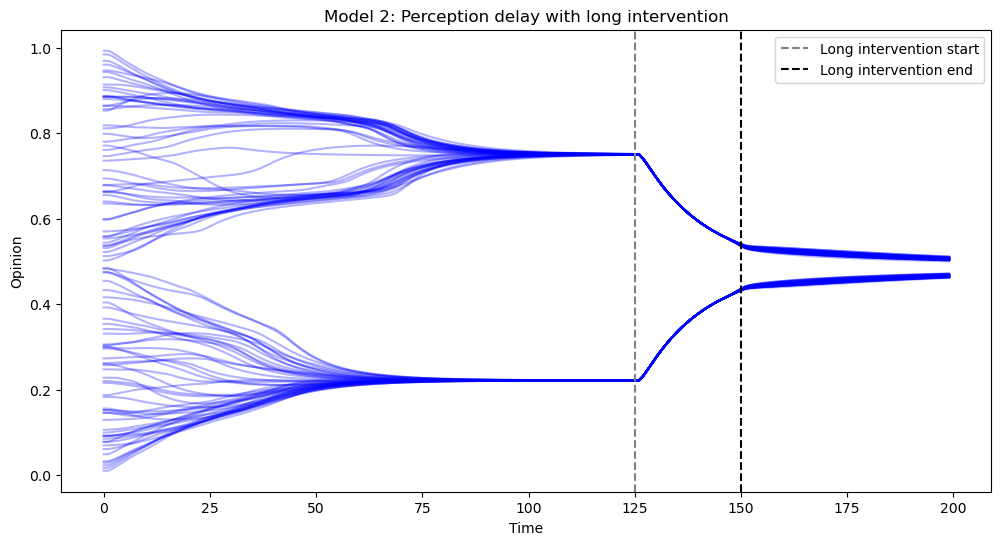

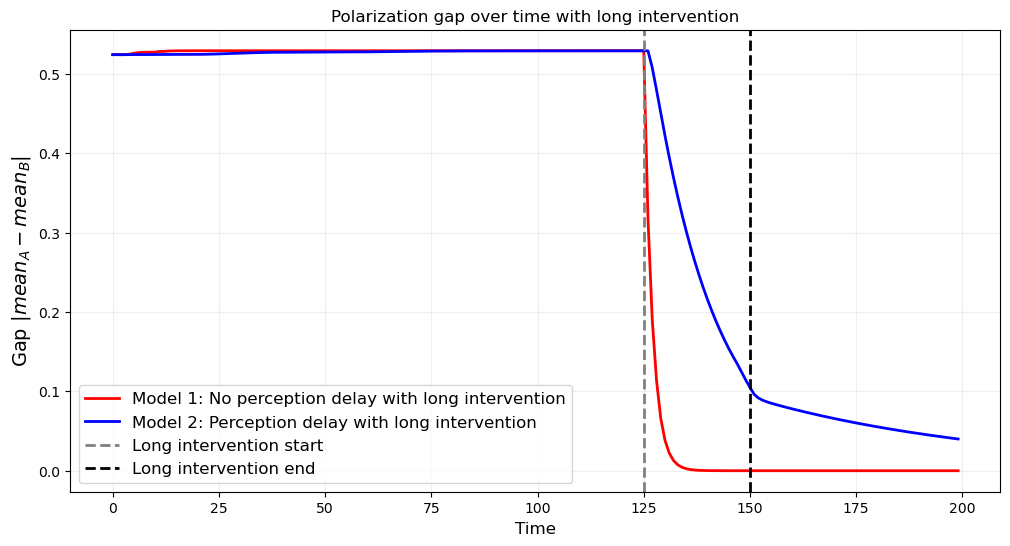

In [ ]:
# Newly added: Long-duration intervention 

# set a longer intervention duration
long_duration = 25

def model1_no_delay_long_intervention(x_init):
    x = x_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()
        x_new = x.copy()

        u = x.mean()  # global signal u(t)
        I_t = (t_intervene <= t < t_intervene + long_duration)

        for i in range(N):
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])  # social signal
            else:
                s_i = x[i]

            if I_t:
                p_i = (1 - eta) * s_i + eta * u
            else:
                p_i = s_i

            x_new[i] = x[i] + mu * (p_i - x[i])

        x = x_new.copy()
    return history


def model2_fixed_delay_long_intervention(x_init, p_init):
    x = x_init.copy()
    p = p_init.copy()
    history = np.zeros((N, T))

    for t in range(T):
        history[:, t] = x.copy()

        x_new = x.copy()
        p_new = p.copy()

        u = x.mean()  # global signal
        I_t = (t_intervene <= t < t_intervene + long_duration)

        for i in range(N):
            neigh = [j for j in neighbors_list[i]
                     if abs(x[i] - x[j]) < epsilon]
            if len(neigh) > 0:
                s_i = np.mean(x[neigh])
            else:
                s_i = x[i]

            # perception update from neighbors
            dp = (1 / tau_fixed) * (s_i - p[i])

            # add long intervention contribution on p
            if I_t:
                dp += (eta / tau_fixed) * (u - p[i])

            p_new[i] = p[i] + dp

            # opinion update uses p(t)
            x_new[i] = x[i] + mu * (p[i] - x[i])

        x = x_new.copy()
        p = p_new.copy()
    return history


# Run simulations with long intervention
hist1_long = model1_no_delay_long_intervention(x0)
hist2_long = model2_fixed_delay_long_intervention(x0, p0)

gap1_long = polarization_gap(hist1_long)
gap2_long = polarization_gap(hist2_long)


# Plot trajectories with long intervention
titles_long = ["Model 1: No perception delay with long intervention",
               "Model 2: Perception delay with long intervention"]
colors_long = ["red", "blue"]
histories_long = [hist1_long, hist2_long]

for hist, title, color in zip(histories_long, titles_long, colors_long):
    plt.figure(figsize=(12, 6))
    for i in range(N):
        plt.plot(hist[i], alpha=0.3, color=color)
    plt.axvline(t_intervene, color="grey", linestyle="--",
                label="Long intervention start")
    plt.axvline(t_intervene + long_duration, color="black", linestyle="--",
                label="Long intervention end")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Opinion")
    plt.legend()
    plt.show()


plt.figure(figsize=(12, 6))

plt.plot(gap1_long, label="Model 1: No perception delay with long intervention", color="red", linewidth=2)
plt.plot(gap2_long, label="Model 2: Perception delay with long intervention", color="blue", linewidth=2)

# intervention markers
plt.axvline(t_intervene, color="grey", linestyle="--", linewidth=2,
            label="Long intervention start")
plt.axvline(t_intervene + long_duration, color="black", linestyle="--", linewidth=2,
            label="Long intervention end")

plt.title("Polarization gap over time with long intervention", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Gap $|mean_A - mean_B|$", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.2)

plt.show()


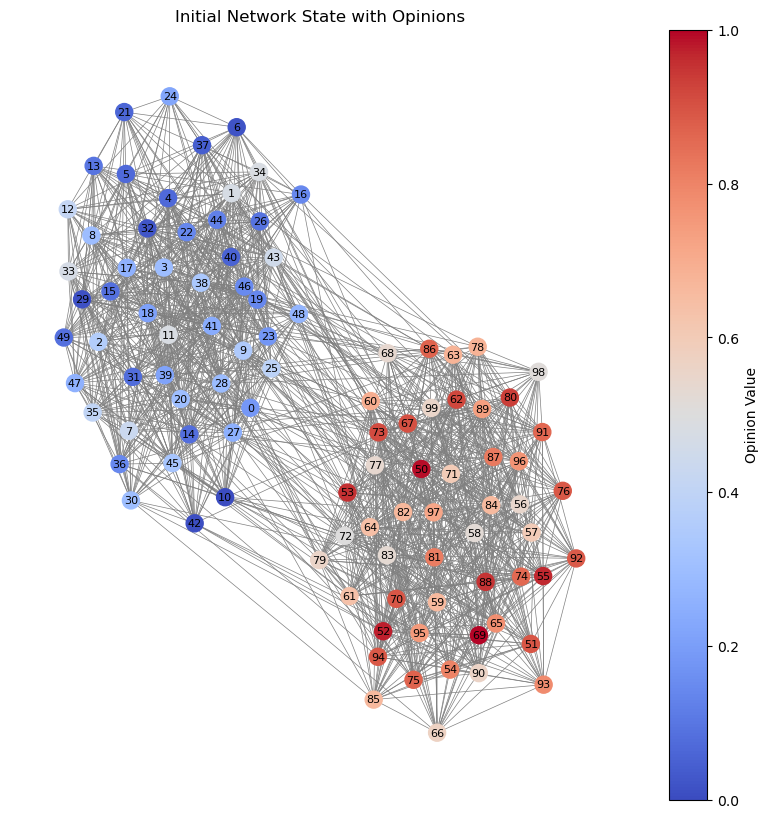

In [ ]:
# Visualize the initial network state

cmap = plt.cm.coolwarm  
norm = plt.Normalize(vmin=0, vmax=1)
pos = nx.spring_layout(G, seed=42, k=0.15) 

# Plot the network with node colors based on initial opinions
plt.figure(figsize=(10, 10))
ax = plt.gca() 
nx.draw(G, pos, node_size=150, node_color=x0, cmap=cmap, 
        with_labels=True, font_size=8, font_color="black", 
        edge_color="gray", width=0.5, alpha=1.0)  

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax, label="Opinion Value")
cbar.ax.tick_params(labelsize=10) 

plt.title("Initial Network State with Opinions")
plt.show()
